# Lab Assignment 4
## Naive Bayes Classifier

```txt
Gaurang Velingkar
191IT113
```

Implement a Naive Bayes Classifier on the IRIS and SPECT Datasets and report the following:
1. Correctly classified instances
2. Incorrectly classified instances
3. Kappa Statistics
4. RMSE
5. Relative Absolute Error
6. Confusion Matrix
7. True Positive Rate and False Positive Rate

Load dataset from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import all required libraries

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_absolute_error

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Load the datasets as a dataframe

In [ ]:
spect_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/CustomDatasets/Heart_Dataset.xlsx',  sheet_name='Sheet1', header=None)
spect_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,0,0,0,1,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,0
1,1,0,0,1,1,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,1
2,1,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
4,1,0,0,0,0,0,0,0,1,0,...,1,0,1,1,0,0,0,0,0,0


In [ ]:
dataset = load_iris()
iris_df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
iris_df['target'] = pd.Series(dataset.target)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Naive bayes model logic

In [ ]:
class NaiveBayes:
  def gaussian_fit(self, X, y):
    self.n_samples, self.n_features = X.shape
    self.n_classes = len(np.unique(y))

    self.mean = np.zeros((self.n_classes, self.n_features))
    self.variance = np.zeros((self.n_classes, self.n_features))
    self.prior_pred = np.zeros(self.n_classes)

    for clas in range(self.n_classes):
      X_c = X[y == clas]

      self.mean[clas, :] = np.mean(X_c, axis=0)
      self.variance[clas, :] = np.var(X_c, axis=0)
      self.prior_pred[clas] = X_c.shape[0] / self.n_samples

  def gaussian_predict(self, X):
    pred = [self.get_gaussian_probability(x) for x in X]
    return pred

  def get_gaussian_probability(self, x):
    posterior_prob = []

    for clas in range(self.n_classes):
      mean = self.mean[clas]
      vari = self.variance[clas]
      prior_pred = np.log(self.prior_pred[clas])

      posterior_pred = np.sum(np.log(self.gaussian_density(x, mean, vari)))
      posterior_pred = prior_pred + posterior_pred
      posterior_prob.append(posterior_pred)

    return np.argmax(posterior_prob)

  def gaussian_density(self, x, mean, variance):
    const = 1 / np.sqrt(2 * np.pi * variance)
    proba = np.exp(-0.5 * ((x - mean) ** 2 / variance))

    return const * proba

  def discrete_fit(self, X, y):
    self.n_samples, self.n_features = X.shape
    self.n_classes = len(np.unique(y))
    self.likelihood_prob = np.zeros((self.n_classes, self.n_features))
    self.prior_prob = np.zeros(self.n_classes)

    for clas in range(self.n_classes):
      x = X[y == clas]
      self.prior_prob[clas] = x.shape[0] / self.n_samples

      for feature in range(self.n_features):
        self.likelihood_prob[clas][feature] = np.log((np.sum(x[:, feature]) + 1) / (len(x) + 1))

  def discrete_predict(self, X):
    pred = [self.get_discrete_probability(x) for x in X]
    return pred

  def get_discrete_probability(self, x):
    posterior_prob = []

    for clas in range(self.n_classes):
      posterior_prob.append(np.sum(self.likelihood_prob[clas]) + np.log(self.prior_prob[clas]))

    return np.argmax(posterior_prob)

In [ ]:
def performance_measures_continuous(cm):
  fp = cm.sum(axis=0) - np.diag(cm)
  fn = cm.sum(axis=1) - np.diag(cm)
  tp = np.diag(cm)
  tn = cm.sum() - (fp + fn + tp)

  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)

  print_tpr = '\n'.join([f' {idx} --> {tprr:.03f}' for idx, tprr in enumerate(tpr)])
  print_fpr = '\n'.join([f' {idx} --> {fprr:.03f}' for idx, fprr in enumerate(fpr)])

  print(f'\nTrue Positive Rate (Sensitivity) for each class:\n{print_tpr}')
  print(f'\nFalse Positive Rate (Fall Out) for each class:\n{print_fpr}')

  return tp, fp, tn, fn

In [ ]:
def performance_measures_discrete(test_y, y_pred):
  tp = 0
  fp = 0
  tn = 0
  fn = 0

  for i in range(len(test_y)):
    if test_y[i] == y_pred[i] == 1:
      tp += 1
    if test_y[i] != y_pred[i] and test_y[i] == 1:
      fn += 1
    if test_y[i] == y_pred[i] == 0:
      tn += 1
    if test_y[i] != y_pred[i] and test_y[i] == 0:
      fp += 1

  print(f'True Positive Rate (Sensitivity) = {tp/(tp+fn):.03f}')
  print(f'False Positive Rate (Fall Out) = {fp/(fp+tn):.03f}')

  return tp, fp, tn, fn

In [ ]:
def relative_absolute_error(test_y, y_pred):
  return abs(test_y - y_pred).sum() / abs(test_y - test_y.mean()).sum()

### IRIS Dataset

In [ ]:
train_df, test_df = train_test_split(iris_df, test_size=0.2, random_state=21)

In [ ]:
train_data = train_df.to_numpy()
X = train_data.T[:-1].T
y = train_data.T[-1].T

In [ ]:
test_data = test_df.to_numpy()
test_X = test_data.T[:-1].T
test_y = test_data.T[-1].T

In [ ]:
model = NaiveBayes()
model.gaussian_fit(X, y)

In [ ]:
y_pred = model.gaussian_predict(test_X)
print(f'Accuracy for the IRIS Dataset = {100*accuracy_score(test_y, y_pred):.3f} %')

Accuracy for the IRIS Dataset = 96.667 %


In [ ]:
correctly_classified = len(test_y[test_y == y_pred])
incorrectly_classified = len(test_y) - correctly_classified

print(f'Correctly classified instances = {correctly_classified}')
print(f'Incorrectly classified instances = {incorrectly_classified}')

Correctly classified instances = 29
Incorrectly classified instances = 1


In [ ]:
print(f'Kappa Score = {cohen_kappa_score(test_y.tolist(), y_pred)}')

Kappa Score = 0.949238578680203


In [ ]:
print(f'Root Mean Square Error (RMSE) = {np.sqrt(((y_pred - test_y) ** 2).mean())}')

Root Mean Square Error (RMSE) = 0.18257418583505536


In [ ]:
print(f'Relative Absolute Error (RAE) = {relative_absolute_error(test_y, y_pred)}')

Relative Absolute Error (RAE) = 0.05244755244755245


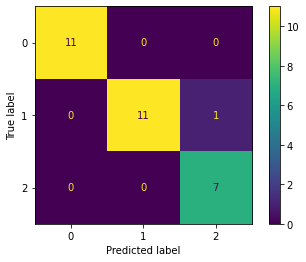

In [ ]:
cm = confusion_matrix(test_y.tolist(), y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

In [ ]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        11
         1.0       1.00      0.92      0.96        12
         2.0       0.88      1.00      0.93         7

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
tp, fp, tn, fn = performance_measures_continuous(cm)


True Positive Rate (Sensitivity) for each class:
 0 --> 1.000
 1 --> 0.917
 2 --> 1.000

False Positive Rate (Fall Out) for each class:
 0 --> 0.000
 1 --> 0.000
 2 --> 0.043


In [ ]:
print(f'Mean Absolute Error (MAE) = {mean_absolute_error(test_y, y_pred)}')

Mean Absolute Error (MAE) = 0.03333333333333333


### SPECT Dataset

In [ ]:
train_df, test_df = train_test_split(spect_df, test_size=0.2, random_state=31)

In [ ]:
train_data = train_df.to_numpy()
X = train_data.T[1:].T
y = train_data.T[0].T

In [ ]:
test_data = test_df.to_numpy()
test_X = test_data.T[1:].T
test_y = test_data.T[0].T

In [ ]:
model = NaiveBayes()
model.discrete_fit(X, y)

In [ ]:
y_pred = model.discrete_predict(test_X)
print(f'Accuracy for the SPECT Dataset = {100*accuracy_score(test_y, y_pred):.3f} %')

Accuracy for the SPECT Dataset = 81.250 %


In [ ]:
correctly_classified = len(test_y[test_y == y_pred])
incorrectly_classified = len(test_y) - correctly_classified

print(f'Correctly classified instances = {correctly_classified}')
print(f'Incorrectly classified instances = {incorrectly_classified}')

Correctly classified instances = 13
Incorrectly classified instances = 3


In [ ]:
print(f'Kappa Score = {cohen_kappa_score(test_y.tolist(), y_pred)}')

Kappa Score = 0.0


In [ ]:
print(f'Root Mean Square Error (RMSE) = {np.sqrt(((y_pred - test_y) ** 2).mean())}')

Root Mean Square Error (RMSE) = 0.4330127018922193


In [ ]:
print(f'Relative Absolute Error (RAE) = {relative_absolute_error(test_y, y_pred)}')

Relative Absolute Error (RAE) = 0.6153846153846154


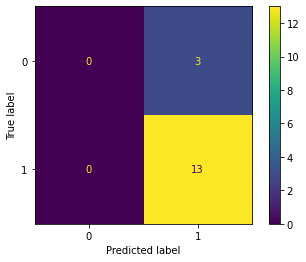

In [ ]:
cm = confusion_matrix(test_y.tolist(), y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()

In [ ]:
tp, fp, tn, fn = performance_measures_discrete(test_y, y_pred)

True Positive Rate (Sensitivity) = 1.000
False Positive Rate (Fall Out) = 1.000


In [ ]:
print(f'Mean Absolute Error (MAE) = {mean_absolute_error(test_y, y_pred)}')

Mean Absolute Error (MAE) = 0.1875
